In [1]:
import pandas as pd
import numpy as np
import os
import re, string
import codecs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input, LSTM,Embedding,Dropout,Activation
from tensorflow.keras.layers import Bidirectional,GlobalMaxPool1D
from tensorflow.keras.models import Model
from keras import initializers,regularizers,constraints,optimizers,layers
from keras import backend as k
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize,TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y,check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, train_test_split
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('wordnet')
import gc
import matplotlib.gridspec as gridspec
import pyLDAvis.gensim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from nltk.tokenize.toktok import ToktokTokenizer
from scipy import sparse

Using TensorFlow backend.
[nltk_data] Downloading package wordnet to /Users/Shuqing/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/Shuqing/.pyenv/versions/3.7.7/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
train=pd.read_csv(os.path.join(os.getcwd(),'data/toxic_comments/train.csv'))
test=pd.read_csv(os.path.join(os.getcwd(),'data/toxic_comments/test.csv'))

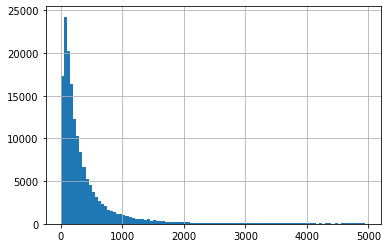

In [3]:
train.comment_text.str.len().hist(bins=np.arange(0,5000,50))

In [10]:
list_classes=['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
y=train[list_classes].values
list_sentences_train=train['comment_text']
list_sentences_test=test['comment_text']

## Steps:
- Tokennization - break down setence into unique words
- Indexing - put words into a dict-like structure
- Index Representation - represent the sequence of words in the form of index, feed this chain of index into LSTM
- Padding - fill the shortfall of short sentences with zeros and trim the longer one to the same length

In [11]:
list_classes =['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
y=train[list_classes].values
list_sentences_train=train['comment_text']
list_sentences_test=test['comment_text']

In [ ]:
max_features=20000
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train=tokenizer.texts_to_sequences(list_sentences_train)
maxlen=200
X_t=pad_sequences(list_tokenized_train,maxlen=maxlen)
X_te=pad_sequences(list_tokenized_test,maxlen=maxlen)

(array([21439., 27127., 22176., 16223., 12859., 10062.,  7586.,  5991.,
         4731.,  3914.,  3129.,  2820.,  2306.,  1896.,  1647.,  1455.,
         1329.,  1287.,  1013.,   857.,   750.,   799.,   528.,   581.,
          486.,   437.,   407.,   373.,   386.,   292.,   284.,   242.,
          217.,   169.,   156.,   167.,   158.,   133.,   136.,   116.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400]),
 <a list of 40 Patch objects>)

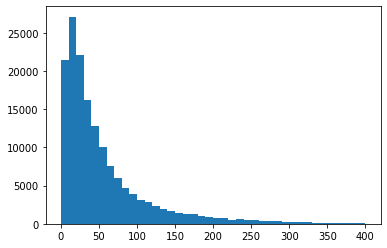

In [203]:
totalNumWords=[ len(t) for t in list_tokenized_train]
plt.hist(totalNumWords,bins=np.arange(0,410,10))

In [214]:
inp=Input(shape=(maxlen,))

In [216]:
# Embedding: we project the words to a defined vector space 
# it helps us to reduce model sizes and high dimensions 
# Embedding layers is a list of coordinates of words in vector space 
embed_size=128
x=Embedding(max_features,embed_size)(inp) # 3-D tensor (None,200, 128)
x=LSTM(60,return_sequences=True,name='lstm_layer')(x)
x=GlobalMaxPool1D()(x) # make it 2-D tensor
x=Dropout(0.1)(x)
x=Dense(50,activation='relu')(x)
x=Dropout(0.1)(x)
x=Dense(6,activation='sigmoid')(x) # 6 labels 
model=Model(inputs=inp,outputs=x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_t,y,batch_size=32,epochs=2,validation_split=0.1)

In [236]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0   

## EDA

In [5]:
## settings
color=sns.color_palette()
sns.set_style('dark')
nltk.download('stopwords')
eng_stopwords=set(stopwords.words('english'))
lem=WordNetLemmatizer()
tokenizer=TweetTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Shuqing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
train['clean']=train.iloc[:,2:].sum(axis=1)==0
train['clean'].sum()
train.iloc[:,2:8].sum().sum()

35098

In [6]:
print('Total comments = {}'.format(len(train)))
print('Total clean comments = {}'.format(train['clean'].sum()))
print('Total tags = {}'.format(train.iloc[:,2:8].sum().sum()))


Total comments = 159571
Total clean comments = 143346
Total tags = 35098


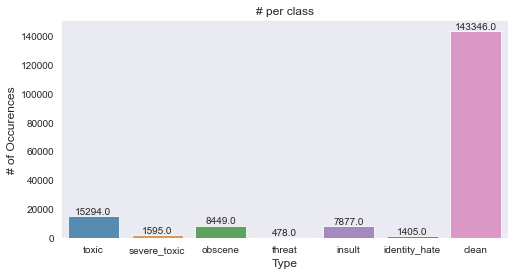

In [49]:
plt.figure(figsize=(8,4))
ax=sns.barplot(train.iloc[:,2:].sum().index,train.iloc[:,2:].sum().values,alpha=0.8)
plt.title('# per class')
plt.ylabel('# of Occurences',fontsize=12)
plt.xlabel('Type',fontsize=12)
rects = ax.patches
labels = train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')


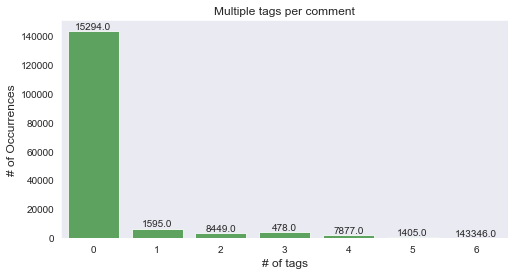

In [26]:
plt.figure(figsize=(8,4))
ax = sns.barplot(train.iloc[:,2:8].sum(axis=1).value_counts().index,train.iloc[:,2:8].sum(axis=1).value_counts().values,
                alpha=0.8,color=color[2])
plt.title('Multiple tags per comment')
plt.ylabel('# of Occurrences',fontsize=12)
plt.xlabel('# of tags',fontsize=12)
rects = ax.patches
labels = train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')


In [7]:
main_col ='toxic'
corr_mats=[]
temp_df=train.iloc[:,2:-1]  
for other_col in temp_df.columns[1:]:
    confusion_matrix=pd.crosstab(temp_df[main_col],temp_df[other_col])
    corr_mats.append(confusion_matrix)

out=pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

In [8]:
def highlight_min(s):
    
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

In [68]:
out.style.apply(highlight_min,axis=0) ## severe_toxic is always toxic 

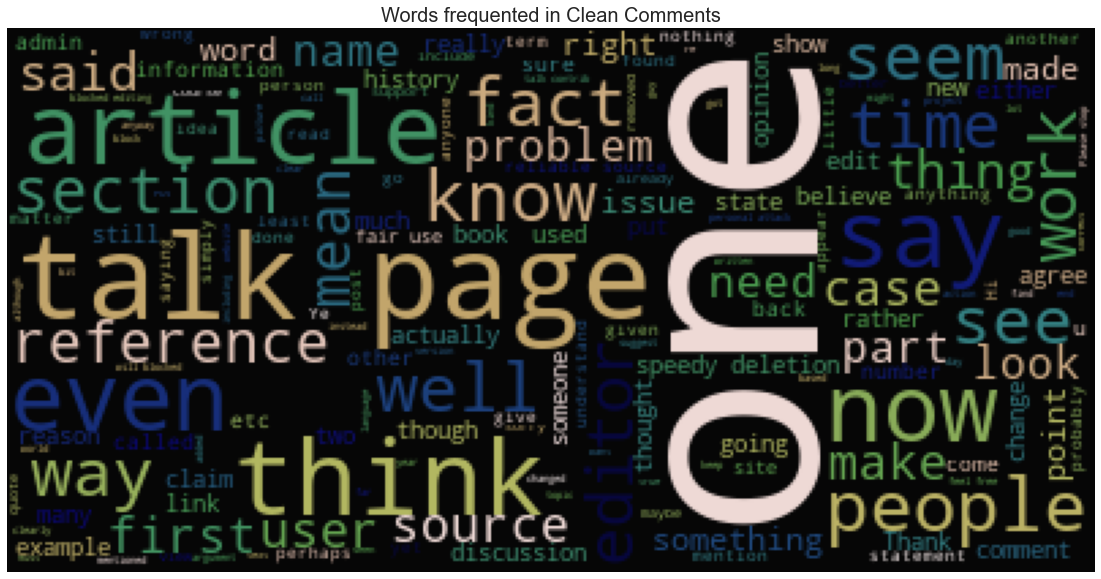

In [114]:
subset=train[train.clean==True]
text=subset.comment_text.values
wc=WordCloud(background_color='black',max_words=2000,stopwords=set(STOPWORDS))
wc.generate(' '.join(text))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('Words frequented in Clean Comments',fontsize=20)
plt.imshow(wc.recolor(colormap='gist_earth',random_state=244),alpha=0.98)

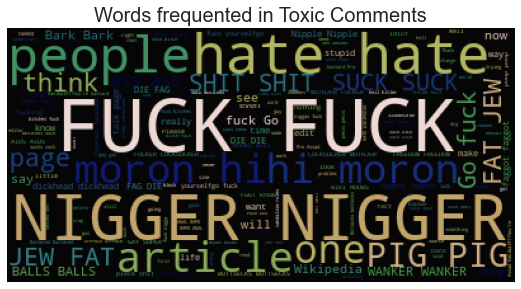

In [112]:
subset=train[train.toxic==1]
text=subset.comment_text.values
wc=WordCloud(background_color='black',max_words=4000,stopwords=set(STOPWORDS))
wc.generate(' '.join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis('off')
plt.title('Words frequented in Toxic Comments',fontsize=20)
plt.imshow(wc.recolor(colormap='gist_earth',random_state=244),alpha=0.98)

In [9]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [10]:
df['count_sent']=df.comment_text.apply(lambda x:len(re.findall('\n',str(x)))+1)
df['count_word']=df.comment_text.apply(lambda x: len(x.split()))
df['count_unique_word']=df.comment_text.apply(lambda x: len(set(str(x).split())))
df['count_letter']=df.comment_text.apply(lambda x: len(str(x)))
df['count_punctuations']=df.comment_text.apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df['count_words_upper']=df.comment_text.apply(lambda x: len([c for c in str(x).split() if c.isupper() ]))
df['count_words_title']=df.comment_text.apply(lambda x:len([c for c in str(x).split() if c.istitle()]))
df['count_stopwords']=df.comment_text.apply(lambda x: len([c for c in str(x).lower().split() if c in eng_stopwords]))
df['mean_word_len']=df.comment_text.apply(lambda x:np.mean([len(c) for c in str(x).split()]))
df['word_unique_percent']=np.round(df.count_unique_word/df.count_word*100,2)
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [11]:
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
train_feats=pd.concat([train_feats,train.iloc[:,2:]],axis=1)
train_tags=train.iloc[:,2:]

Text(0.5, 1.0, 'Number of words in each comment')

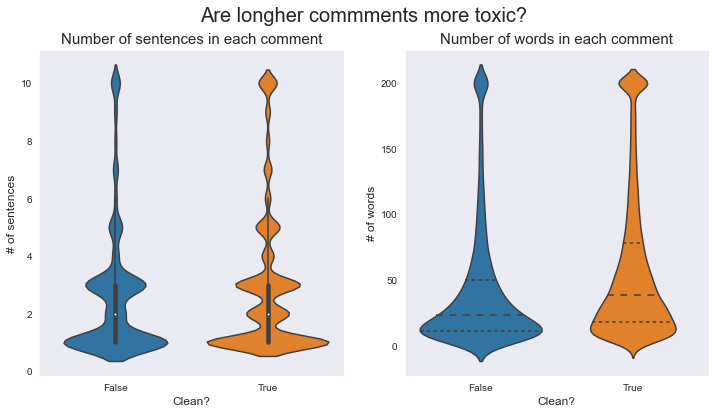

In [10]:
train_feats['count_sent'].loc[train_feats.count_sent>10]=10
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.suptitle('Are longher commments more toxic?',fontsize=20)
sns.violinplot(y='count_sent',x='clean',data=train_feats,split=True)
plt.xlabel('Clean?',fontsize=12)
plt.ylabel('# of sentences',fontsize=12)
plt.title('Number of sentences in each comment',fontsize=15)
train_feats['count_word'].loc[train_feats['count_word']>200]=200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean',data=train_feats,split=True,inner='quart')
plt.xlabel('Clean?',fontsize=12)
plt.ylabel('# of words',fontsize=12)
plt.title('Number of words in each comment',fontsize=15)

In [12]:
train_feats.count_unique_word.loc[train_feats.count_unique_word>200]=200
temp_df=pd.melt(train_feats,value_vars=['count_word','count_unique_word'],id_vars='clean')
spammers=train_feats[train_feats.word_unique_percent<30]

Text(0.5, 0, 'Percent unique words')

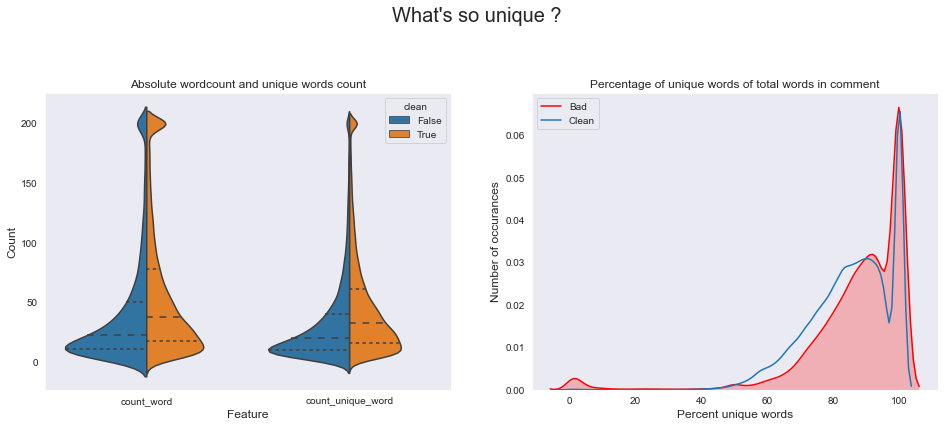

In [95]:
## A bulge near 0-10% mark which indicates large number of toxic comments have very low variablity 
plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
plt.subplot(221)
sns.violinplot(x='variable',y='value',hue='clean',data=temp_df,split=True,inner='quartile')
plt.title('Absolute wordcount and unique words count')
plt.xlabel('Feature',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(222)
plt.title('Percentage of unique words of total words in comment')
ax=sns.kdeplot(train_feats[train_feats.clean==0].word_unique_percent,label='Bad',shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean==1].word_unique_percent,label='Clean')
plt.legend()
plt.ylabel('Number of occurances',fontsize=12)
plt.xlabel('Percent unique words',fontsize=12)

Text(0, 0.5, '# of comments')

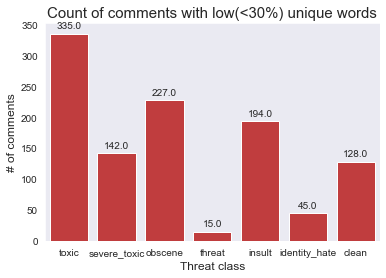

In [97]:
x=spammers.iloc[:,-7:].sum()
plt.title('Count of comments with low(<30%) unique words',fontsize=15)
ax=sns.barplot(x=x.index,y=x.values,color=color[3])
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)

In [13]:
# fetch ip address
df['ip']=df.comment_text.apply(lambda x: re.findall('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}',str(x)))
df['count_ip']=df.ip.apply(lambda x: len(x))
df['link']=df.comment_text.apply(lambda x:re.findall('https://.*com',str(x)))
df['count_link']=df.link.apply(lambda x: len(x))
df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))
df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
#count of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))

In [14]:
cv=CountVectorizer()
count_feats_ip=cv.fit_transform(df.ip.apply(lambda x:str(x)))
cv=CountVectorizer()
count_feats_user=cv.fit_transform(df.username.apply(lambda x:str(x)))

In [15]:
leaky_feats=df[['ip', 'count_ip', 'link',
       'count_link', 'article_id', 'article_id_flag', 'username',
       'count_usernames']]
leaky_feats_train=leaky_feats.iloc[:train.shape[0]]
leaky_feats_test=leaky_feats.iloc[train.shape[0]:]

In [16]:
train_ips=leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips=leaky_feats_test.ip[leaky_feats_test.count_ip!=0]
train_ip_list=list(set([a for b in train_ips for a in b]))
test_ip_list=list(set([a for b in test_ips for a in b]))
common_ip_list=list(set(train_ip_list).intersection(set(test_ip_list)))
train_links=leaky_feats_train.link[leaky_feats_train.count_link!=0]
test_links=leaky_feats_test.link[leaky_feats_test.count_link!=0]
train_links_list=list(set([a for b in train_links for a in b]))
test_links_list=list(set([a for b in test_links for a in b]))
common_links_list=list(set(train_links_list).intersection(set(test_links_list)))
train_users=leaky_feats_train.username[leaky_feats_train.count_usernames!=0]
test_users=leaky_feats_test.username[leaky_feats_test.count_usernames!=0]
train_users_list=list(set([a for b in train_users for a in b]))
test_users_list=list(set([a for b in test_users for a in b]))
ccommon_users_list=list(set(train_users_list).intersection(set(test_users_list)))

In [17]:
corpus=merge.comment_text

In [18]:
APPO={
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [19]:
def clean(comment):
    comment= comment.lower()
    comment=re.sub('\\n','',comment)
    comment=re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}','',comment)
    comment=re.sub('\[\[.*\]]','',comment)
    
    words=tokenizer.tokenize(comment)
    words = [APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word,'v') for word in words]
    words=[w for w in words if not w in eng_stopwords]
    
    clean_sent = ' '.join(words)
    return (clean_sent)

In [20]:
clean_corpus=corpus.apply(lambda x: clean(x))

In [21]:
tfv=TfidfVectorizer(min_df=200,max_features=10000,strip_accents='unicode',
    analyzer='word',ngram_range=(1,1),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words='english')
tfv.fit(clean_corpus)
features=np.array(tfv.get_feature_names())
train_unigrams=tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams=tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
text=['The quick brown fox jumped over the lazy dog.']
vectorizer=CountVectorizer()
vectorizer.fit(text)
vectorizer.vocabulary_ # tokenize and build the vocab
vector=vectorizer.transform(text)
vector.toarray() # shows how it is transformed
vector.shape

(1, 8)

In [23]:
label=train_tags.columns.values

In [24]:
def top_tfidf_feats(row,features,top_n=25):
    topn_ids=np.argsort(row)[::-1][:top_n]
    top_feats=[(features[i],row[i]) for i in topn_ids]
    df=pd.DataFrame(top_feats,columns=['feature','tfidf'])
    return df 
def top_feats_in_doc(Xtr,features,row_id,top_n=25):
    row=np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row,features,top_n)
def top_mean_feats(Xtr,features,grp_ids,min_tfidf=0.1,top_n=25):
    D = Xtr[grp_ids].toarray()
    D[D<min_tfidf]=0
    tfidf_means = np.mean(D,axis=0)
    return top_tfidf_feats(tfidf_means,features,top_n)

def top_feats_by_class(Xtr,features,min_tfidf=0.1,top_n=20):
    dfs=[]
    cols=train_tags.columns
    for col in cols:
        ids=train_tags.index[train_tags[col]==1]
        feats_df=top_mean_feats(Xtr,features,ids,min_tfidf=min_tfidf,top_n=top_n)
        feats_df.label=label
        dfs.append(feats_df)
        
    return dfs

In [25]:
tfidf_top_n_per_class=top_feats_by_class(train_unigrams,features)

Text(0, 0.5, 'TF-IDF score')

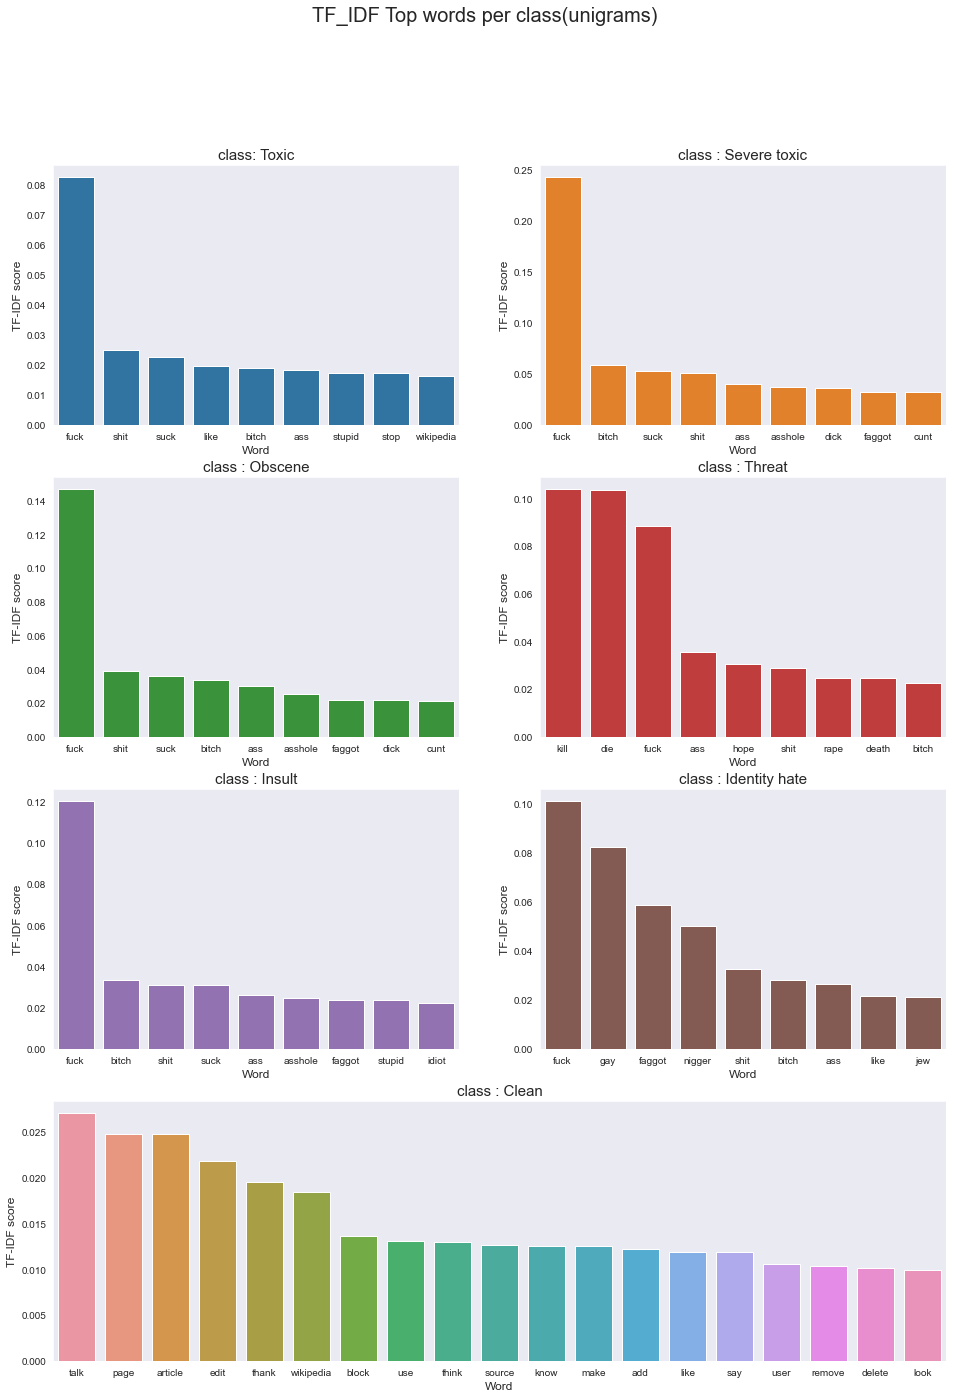

In [30]:
plt.figure(figsize=(16,22))
plt.suptitle('TF_IDF Top words per class(unigrams)',fontsize=20)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_class[0].feature.iloc[0:9],tfidf_top_n_per_class[0].tfidf.iloc[0:9],color=color[0])
plt.title('class: Toxic',fontsize=15)
plt.xlabel('Word',fontsize=12)
plt.ylabel('TF-IDF score',fontsize=12)
plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_class[1].feature.iloc[0:9],tfidf_top_n_per_class[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_class[2].feature.iloc[0:9],tfidf_top_n_per_class[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_class[3].feature.iloc[0:9],tfidf_top_n_per_class[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_class[4].feature.iloc[0:9],tfidf_top_n_per_class[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_class[5].feature.iloc[0:9],tfidf_top_n_per_class[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_class[6].feature.iloc[0:19],tfidf_top_n_per_class[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

In [25]:
tfv=TfidfVectorizer(min_df=150,max_features=30000,strip_accents='unicode',analyzer='word',ngram_range=(2,2),use_idf=1,
                smooth_idf=1,sublinear_tf=1,stop_words='english')
tfv.fit(clean_corpus)
features=np.array(tfv.get_feature_names())
train_bigrams=tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams=tfv.transform(clean_corpus.iloc[train.shape[0]:])
tfidf_top_n_per_class=top_feats_by_class(train_bigrams,features)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=30000,
                min_df=150, ngram_range=(2, 2), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=1, vocabulary=None)

In [27]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letter', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']
target_x=train_feats[SELECTED_COLS]
TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train_tags[TARGET_COLS]
model=LogisticRegression(C=3)
X_train,X_valid,y_train,y_valid=train_test_split(target_x,target_y,test_size=0.33,random_state=2018)
train_loss =[]
valid_loss =[]
importance =[]
preds_train=np.zeros((X_train.shape[0],len(y_train)))
preds_valid=np.zeros((X_valid.shape[0],len(y_valid)))

In [50]:
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i]=model.predict_proba(X_valid)[:,1]
    preds_train[:,i]=model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:',train_loss_class)
    print('Validloss=log loss:',valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column_wise log loss:Train dataset',np.mean(train_loss))
print('mean column_wise log loss:Validation dataset',np.mean(valid_loss))

Class:= toxic
Trainloss=log loss: 0.3014985793850604
Validloss=log loss: 0.3008948880667071
Class:= severe_toxic
Trainloss=log loss: 0.050692937158721134
Validloss=log loss: 0.05185490546849025
Class:= obscene
Trainloss=log loss: 0.20082178514805143
Validloss=log loss: 0.19939319642009323
Class:= threat
Trainloss=log loss: 0.019934095708007454
Validloss=log loss: 0.01929758471417535
Class:= insult
Trainloss=log loss: 0.18962013530881977
Validloss=log loss: 0.190871314503256
Class:= identity_hate
Trainloss=log loss: 0.048570738868556375
Validloss=log loss: 0.05195355678471234
mean column_wise log loss:Train dataset 0.1351897119295361
mean column_wise log loss:Validation dataset 0.1357109076595724


Text(0, 0.5, 'Importance')

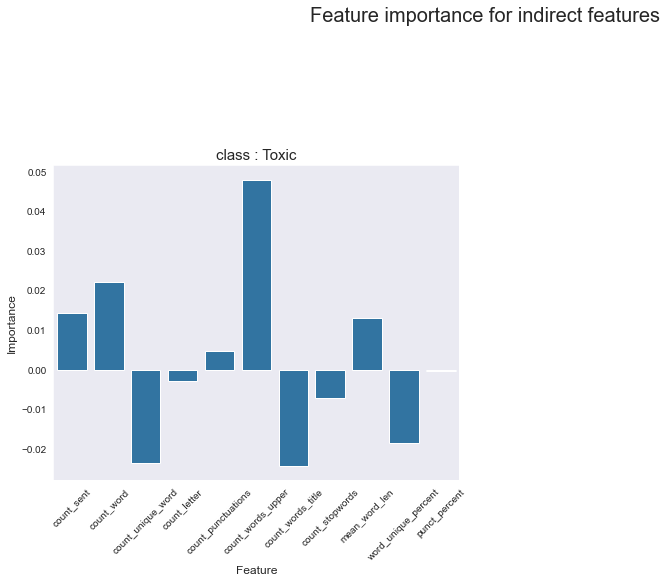

In [57]:
plt.figure(figsize=(16,22))
plt.suptitle('Feature importance for indirect features',fontsize=20)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title('class : Toxic',fontsize=15)
locs,labels =plt.xticks()
plt.setp(labels,rotation=45)
plt.xlabel('Feature',fontsize=12)
plt.ylabel('Importance',fontsize=12)

In [ ]:
class NbSvmClassifer(BaseEstimator,ClassifierMixin):
    def __init__(self,C=1.0,dual=False,n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs =n_jobs
    
    def predict(self,x):
        

In [ ]:
class NbSvmClassifer(BaseEstimator, ClassifierMixin):
    def __init__(self,C=1.0,dual=False,n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs
    
    def predict(self,x):
        check_is_fitted(self,['_r','_clf'])
        return self._clf.predict(x.multiply(self._r))
    
    def predict_proba(self,x):
        check_is_fitted(self,['_r','_clf'])
        return self._clf.predict_proba(x.multiply(self._r))
    
    def fit(self,x,y):
        y = y.values
        x,y = check_X_y(x,y,accept_sparse=True)
        
        def pr(x,y_i,y):
            p = x[y==y_i].sum(0)
            return (p+1)/((y==y_i).sum()+1)
        
        self._r = sparse.csr_matrix(np.log(pr(x,1,y)/pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C,dual=self.dual,n_jobs=self.n_jobs).fit(x_nb,y)
        return self


In [3]:
eng_stopwords=stopwords.words('english')
lem=WordNetLemmatizer()
tokenizer=ToktokTokenizer()
def preprocess(comment):
    return gensim.utils.simple_preprocess(comment, deacc=True,min_len=3)

In [4]:
train_text=train.comment_text.apply(lambda x:preprocess(x))
test_text=test.comment_text.apply(lambda x:preprocess(x))
all_text=train_text.append(test_text)

In [8]:
bigram=gensim.models.Phrases(all_text)

In [10]:
bigram[all_text.iloc[30]]

['how',
 'could',
 'post',
 'before',
 'the',
 'block_expires',
 'the',
 'funny_thing',
 'you',
 'think',
 'being_uncivil']

In [11]:
def clean(word_list):
    clean_words = [w for w in word_list if not w in eng_stopwords]
    clean_words=bigram[clean_words]
    clean_words=[lem.lemmatize(word,'v') for word in clean_words]
    return clean_words

In [12]:
print('Before clean:',all_text.iloc[1])
print('After clean:',clean(all_text.iloc[1]))

Before clean: ['aww', 'matches', 'this', 'background', 'colour', 'seemingly', 'stuck', 'with', 'thanks', 'talk', 'january', 'utc']
After clean: ['aww', 'match', 'background', 'colour', 'seemingly', 'stick', 'thank', 'talk', 'january_utc']


In [13]:
all_text=all_text.apply(lambda x:clean(x))

In [15]:
dictionary=Dictionary(all_text)

In [19]:
print(dictionary.doc2bow(all_text.iloc[1]))
print('Wordlist from the setence:',all_text.iloc[1])
print('Wordlist from the dictionary lookup:',dictionary[21],dictionary[22],dictionary[23],
     dictionary[24],dictionary[25],dictionary[26],dictionary[27],dictionary[28],dictionary[29])

[(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]
Wordlist from the setence: ['aww', 'match', 'background', 'colour', 'seemingly', 'stick', 'thank', 'talk', 'january_utc']
Wordlist from the dictionary lookup: aww background colour january_utc match seemingly stick talk thank


In [22]:
corpus=[dictionary.doc2bow(text) for text in all_text]

In [26]:
ldamodel=LdaModel(corpus=corpus,num_topics=15,id2word=dictionary)

In [27]:
pyLDAvis.enable_notebook()

In [28]:
pyLDAvis.gensim.prepare(ldamodel,corpus,dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.232027 -0.058860       1        1  17.607285
1     -0.240903 -0.048500       2        1  15.381109
14    -0.245056 -0.007697       3        1  15.098715
10    -0.174532 -0.184627       4        1  14.452063
4      0.094445 -0.227623       5        1   5.380160
12    -0.105114  0.164643       6        1   4.704172
3     -0.111306  0.093159       7        1   4.438265
9      0.110543 -0.215236       8        1   4.210286
8     -0.062933  0.161664       9        1   4.055153
13     0.011914  0.239930      10        1   3.938408
2      0.187424 -0.117096      11        1   2.755754
0      0.161560 -0.126333      12        1   2.568675
5      0.153276  0.187922      13        1   2.187152
6      0.213952 -0.051579      14        1   1.665767
7      0.238758  0.190233      15        1   1.557034, topic_info=            Term           Freq          Total Category  logprob  loglift
46       article  149895.000000  149895.000000  Default  30.0000  30.0000
2           edit   61119.000000   61119.000000  Default  29.0000  29.0000
79     wikipedia   82671.000000   82671.000000  Default  28.0000  28.0000
784         fuck   37252.000000   37252.000000  Default  27.0000  27.0000
83          page   76571.000000   76571.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
10950  viewpoint     681.281067     742.381287  Topic15  -5.3464   4.0765
1877    election     720.251160    1037.966919  Topic15  -5.2908   3.7970
2998      idiots     793.707031    1773.123901  Topic15  -5.1937   3.3586
1474        paul     733.661499    1186.620361  Topic15  -5.2723   3.6816
13482     supply     698.671631    1054.209839  Topic15  -5.3212   3.7510

[991 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
605       1  0.001383   absurd
605       2  0.997054   absurd
1491      1  0.264563  account
1491      2  0.004018  account
1491      3  0.081742  account
...     ...       ...      ...
1813     10  0.048522    years
1813     13  0.006982    years
6171      5  0.997080     yell
3140     10  0.998647  youtube
9790     14  0.998006     zone

[2754 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 2, 15, 11, 5, 13, 4, 10, 9, 14, 3, 1, 6, 7, 8])

In [29]:
topic_probability_mat=ldamodel[corpus]
train_matrix=topic_probability_mat[:train.shape[0]]
test_matrix=topic_probability_mat[train.shape[0]:]

In [34]:
train_sparse=gensim.matutils.corpus2csc(train_matrix)
test_sparse=gensim.matutils.corpus2csc(test_matrix)

In [36]:
target_x=train_sparse.transpose()
TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train[TARGET_COLS]